In [1]:
import pandas as pd
import numpy as np
from nltk.metrics import edit_distance    
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.decomposition import KernelPCA, PCA
from sklearn.manifold import MDS

import glob
path = "*.csv"

In [2]:
lexData = pd.read_csv("Gregorian Chant Data - LexDomini.csv")
benData = pd.read_csv("Gregorian Chant Data - Benedicite Dominum.csv")
domData = pd.read_csv("Gregorian Chant Data - Dominus Dixit.csv")
factusData = pd.read_csv("Gregorian Chant Data - Factus Est.csv")
rorateData = pd.read_csv("Gregorian Chant Data - Rorate.csv")
sicutData = pd.read_csv("Gregorian Chant Data - Sicut Oculi.csv")

In [3]:
all_locations = ['Ben', 'Rome1', 'Klo', 'Leipzig', 'Rou2', 'Amb1', 'Amb3', 'Amb2', 'NIt', 'Dij',
            'Ger2', 'Ger1', 'Moosburg', 'Gai', 'Arne', 'St. Yrieix', 'Paris', 'Sens', 'Aux',
            'Che', 'Rou1', 'Nev', 'Rome3', 'Rome2', 'MCa', 'Aqu', 'Ven', 'VimA', 'VimB','VimC', 'VimD']
all_matrix = pd.DataFrame(columns=all_locations)
all_matrix


,Ben,Rome1,Klo,Leipzig,Rou2,Amb1,Amb3,Amb2,NIt,Dij,...,Nev,Rome3,Rome2,MCa,Aqu,Ven,VimA,VimB,VimC,VimD


In [4]:
#Distance Metric: MSE

def mseMatrix(m):
    num_location = len(m.columns[1:])
    result = pd.DataFrame(index=m.columns[1:], columns=m.columns[1:],)
    sumSquares = 0
    
    for i in range(1,len(m.columns)):
        for j in range(1,len(m.columns)):
            if(i==j): sumSquares = 0
            else:
                diff_vector = m.ix[:,i] - m.ix[:,j]
                diff_vector = diff_vector.fillna(value=1)
                diff_vector = diff_vector ** 2
                sumSquares = sum(diff_vector) / len(diff_vector)
            result.ix[i-1, j-1] = sumSquares

    return result

In [5]:
#Distance Metric: Euclidean

def euclidMatrix(m):
    num_location = len(m.columns[1:])
    result = pd.DataFrame(index=m.columns[1:], columns=m.columns[1:],)
    sumSquare = 0
    
    for i in range(1, len(m.columns)):
        for j in range(1, len(m.columns)):
            if i == j: sumSquares = 0
            else:
                diff_vector = m.ix[:,i] - m.ix[:,j]
                diff_vector = diff_vector.fillna(value=1)
                diff_vector = diff_vector ** 2
                sumSquares = sum(diff_vector)
            result.ix[i-1, j-1] = sumSquares ** 1/2
            
    return result

In [6]:
#Distance Metric: Pearson's Distance

def pearsonMatrix(m):
    return m.corr()

In [7]:
#Distance Metric: Manhattan Distance

def manhattanMatrix(m):
    num_location = len(m.columns[1:])
    result = pd.DataFrame(index=m.columns[1:], columns=m.columns[1:],)
    diff = 0
    
    for i in range(1, len(m.columns)):
        for j in range(1, len(m.columns)):
            if i == j: diff = 0
            else:
                diff_vector = abs(m.ix[:,i] - m.ix[:,j])
                diff_vector = diff_vector.fillna(value=1)
                diff = sum(diff_vector)
            result.ix[i-1, j-1] = diff
            
    return result

In [8]:
#Distance Metric: Canberra Distance (weighted Manhattan)

def canberraMatrix(m):
    num_location = len(m.columns[1:])
    result = pd.DataFrame(index=m.columns[1:], columns=m.columns[1:],)
    diff = 0
    
    for i in range(1, len(m.columns)):
        for j in range(1, len(m.columns)):
            if i == j: diff = 0
            else:
                diff_vector = abs(m.ix[:,i] - m.ix[:,j]) / (abs(m.ix[:,i]) + abs(m.ix[:,j]))
                diff_vector = diff_vector.fillna(value=1)
                diff = sum(diff_vector)
            result.ix[i-1, j-1] = diff
            
    return result


In [9]:
def adistMatrix(m):
    
    def int_to_alpha(m):
        note_val = {0:"a", -1:"b", -2:"c", -3:"d", -5:"e", -7:"f", -8:"g", -10:"h", -12:"i", 2:"j", 5:"k"}
        num_location = len(m.columns[1:])
        new_df = pd.DataFrame(index=[0],columns=m.columns[1:])
        empty_col = ""
    
        def convert(n):
            if pd.isnull(n): return ""
            if n in note_val: return note_val[n]
            else: return "|no conversion|"

        for i in range(1,len(m.columns)):
            for j in range(len(m)):
                empty_col = empty_col + convert(m.ix[:,i][j])
            new_df.ix[0, i-1] = empty_col
            empty_col = ""
    
        return new_df

    num_location = len(m.columns[1:])
    result = pd.DataFrame(index=m.columns[1:], columns=m.columns[1:])
    trans_m = int_to_alpha(m)

    adist = 0
    
    for i in range(len(trans_m.columns)):
        for j in range(len(trans_m.columns)):
            if i == j: adist = 0
            else:
                adist = edit_distance(trans_m.ix[0][i], trans_m.ix[0][j])
            result.ix[i, j] = adist
            
            
    return result  

In [10]:
#distance_list = [mseMatrix, euclidMatrix, pearsonMatrix, manhattanMatrix, canberraMatrix, adistMatrix]

def get_small_large(mat_func):
    
    smallest = 1000
    largest = -1000
    
    for chant_name in glob.glob(path):
        data = pd.read_csv(chant_name)
        temp_mat = mat_func(data)
        temp_mat.fillna(value=np.nan, inplace = True)
        temp_large = temp_mat.select_dtypes(include=[np.number]).max().max()
        temp_small = temp_mat.select_dtypes(include=[np.number]).min().min()
        if temp_large > largest:
            largest = temp_large
        if temp_small < smallest:
            smallest = temp_small
        #print("largest: ", largest)
        #print("smallest: ", smallest)
    return largest, smallest

mse_largest, mse_smallest = get_small_large(mseMatrix)
euclid_largest, euclid_smallest = get_small_large(euclidMatrix)
pearson_largest, peason_smallest = get_small_large(pearsonMatrix)
manhattan_largest, manhattan_smallest = get_small_large(manhattanMatrix)
canberra_largest, canberra_smallest = get_small_large(canberraMatrix)
adist_largest, adist_smallest = get_small_large(adistMatrix)


In [11]:
def normFrame(mat_func, chant):
    
    smallest = 1000
    largest = -1000
    
    for chant_name in glob.glob(path):
        data = pd.read_csv(chant_name)
        temp_mat = mat_func(data)
        temp_mat.fillna(value=np.nan, inplace = True)
        temp_large = temp_mat.select_dtypes(include=[np.number]).max().max()
        temp_small = temp_mat.select_dtypes(include=[np.number]).min().min()
        if temp_large > largest:
            largest = temp_large
        if temp_small < smallest:
            smallest = temp_small
        #print("largest: ", largest)
        #print("smallest: ", smallest)
    
    matrix = mat_func(chant)
    matrix.fillna(value=np.nan, inplace = True)
    return (matrix - smallest) / (largest - smallest)



--- 27.661375045776367 seconds ---


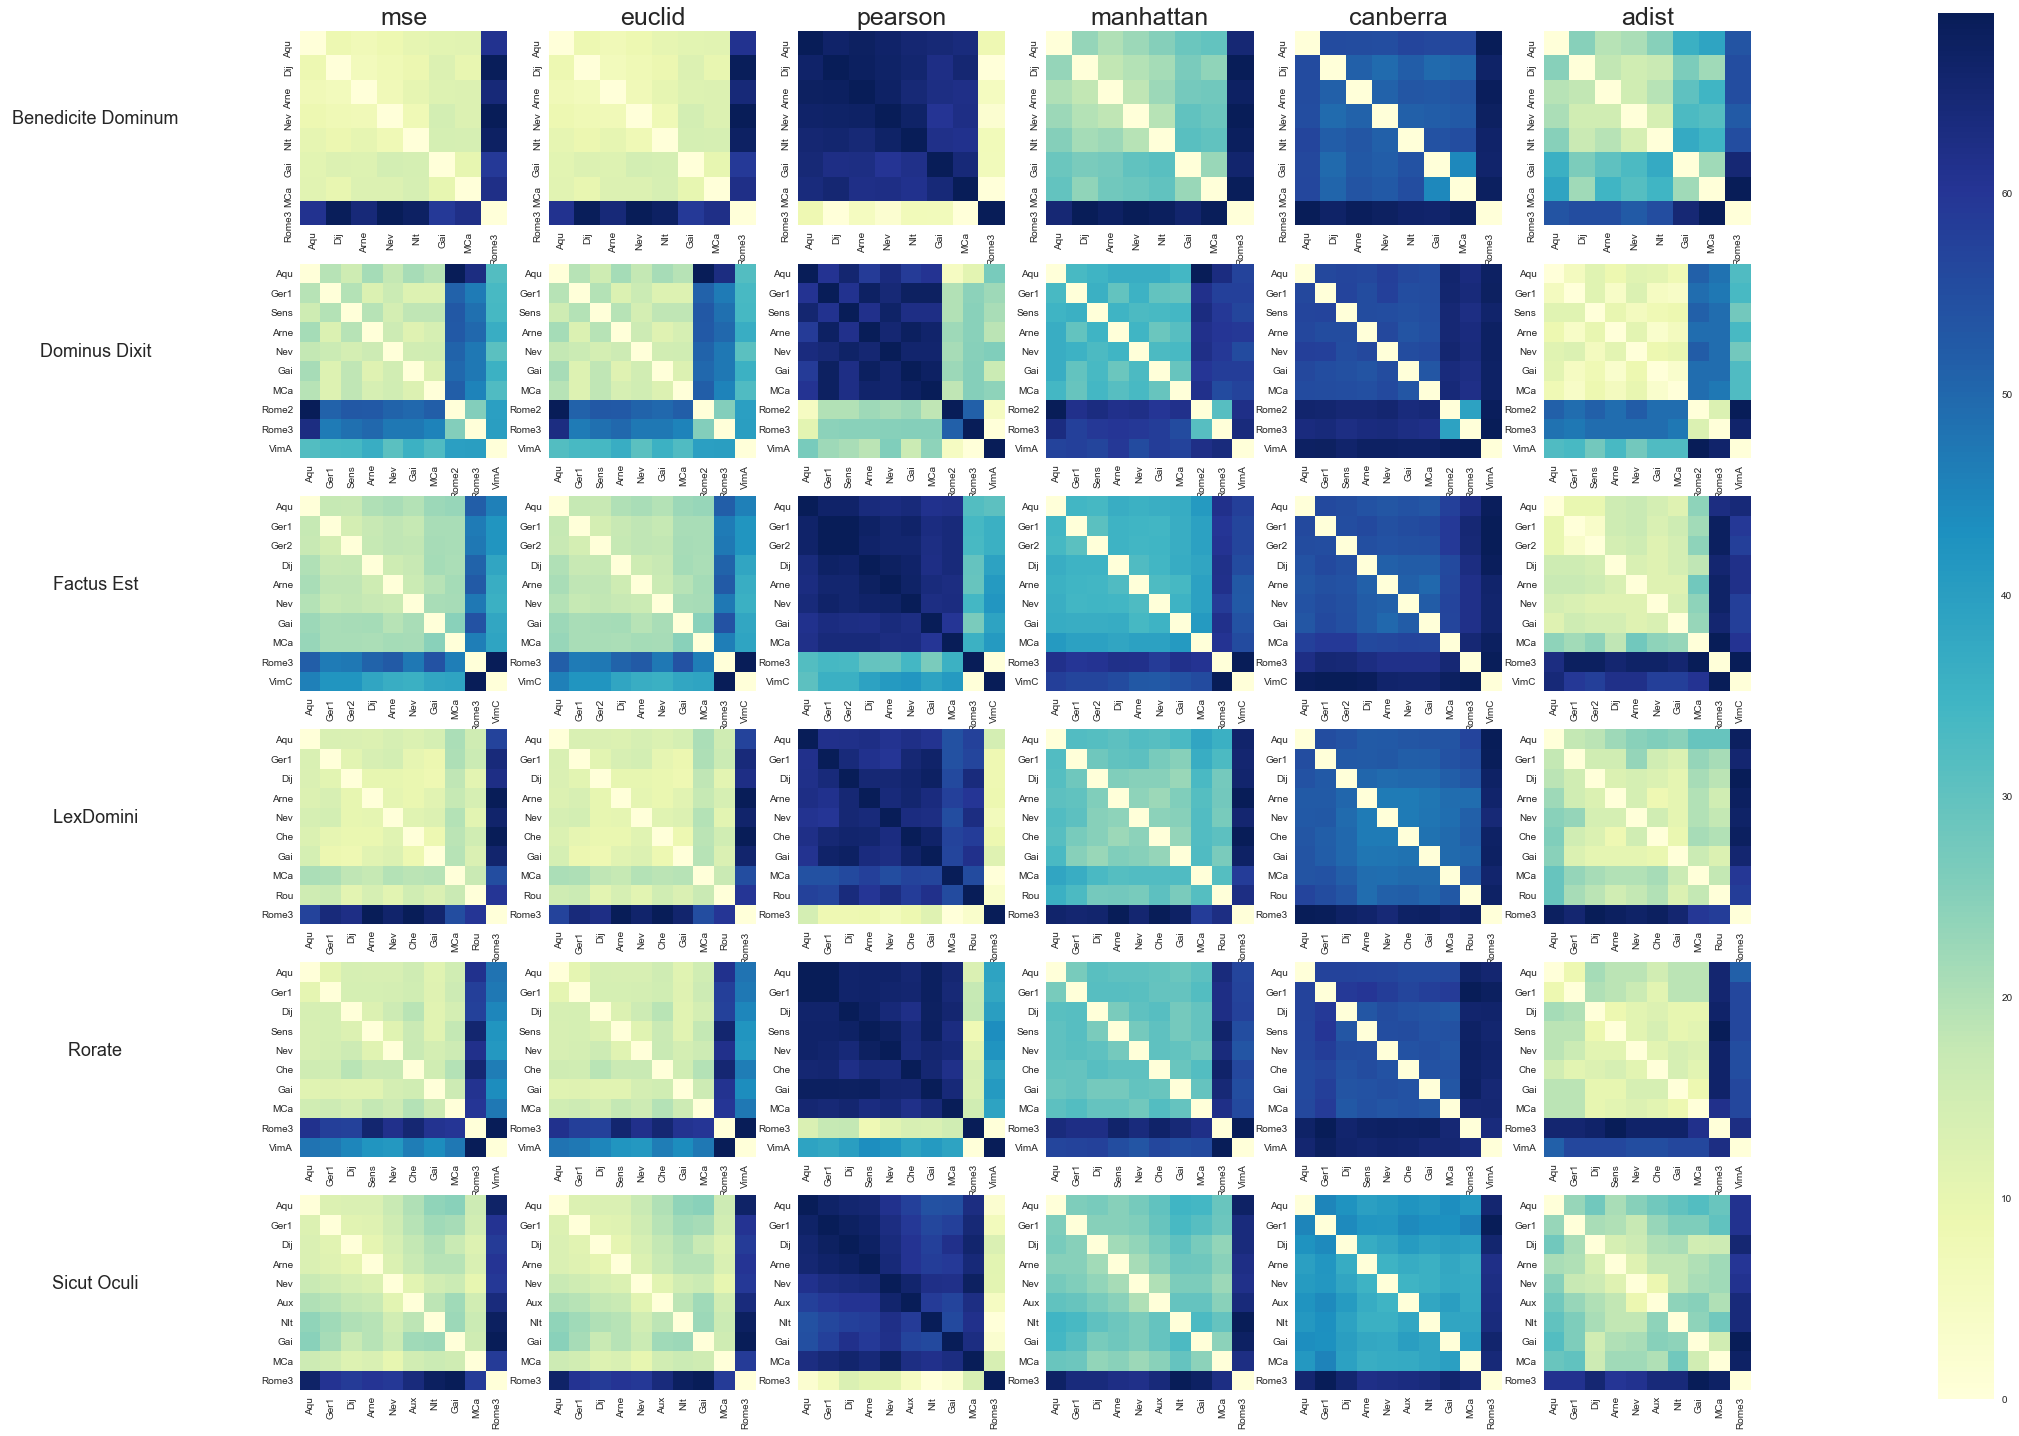

In [12]:
start_time = time.time()
chants = glob.glob(path)

f, axarr = plt.subplots(len(chants),6)

f.set_figheight(25)
f.set_figwidth(26)

j=0
d_count = 0
chant_count = 0
distance_list = [mseMatrix, euclidMatrix, pearsonMatrix, manhattanMatrix, canberraMatrix, adistMatrix]
chant_list = []

for chant_name in chants:
    
    chant_list.append(chants[j].split("-")[1].split(".")[0])
    j+= 1
    
    for i in distance_list:
        
        data = pd.read_csv(chant_name)
        matrix = i(data)
        matrix.fillna(value=np.nan, inplace=True)
        sns.heatmap(matrix,cmap="YlGnBu",cbar=False, ax=axarr[chant_count][d_count])
        d_count+=1
 
    d_count=0
    chant_count+=1

cols = ["mse", "euclid", "pearson", "manhattan", "canberra", "adist"]
rows = ['{}'.format(row) for row in chant_list]
for ax, col in zip(axarr[0], cols):
    ax.set_title(col, fontsize = 25)

for ax, row in zip(axarr[:,0], rows):
    ax.set_ylabel(row, rotation=0, fontsize = 18)
    ax.yaxis.set_label_coords(-1,0.5)

im = plt.gca().get_children()[0]
cax = f.add_axes([1.0,0.12,0.03,0.77]) 
f.colorbar(im, cax=cax)

print("--- %s seconds ---" % (time.time() - start_time))

# Ignore code below

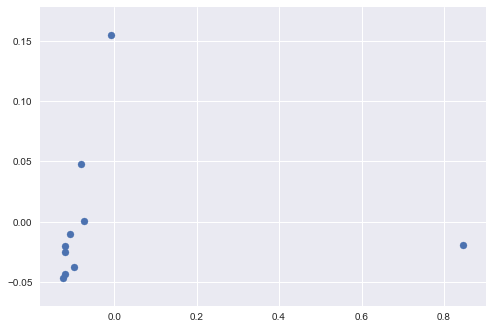

In [13]:
kpca = KernelPCA(n_components=2, kernel="rbf")
test = kpca.fit_transform(normFrame(mseMatrix, lexData))
test = pd.DataFrame(test)
plt.scatter(test[0], test[1])

In [14]:
mds = MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=1)
out = mds.fit(normFrame(mseMatrix, rorateData)).embedding_
out

array([[-0.04218053, -0.15079725],
       [-0.07546474, -0.11192696],
       [-0.02867997,  0.0046692 ],
       [ 0.08695406, -0.09944602],
       [ 0.07872922, -0.02879785],
       [ 0.04700767, -0.20608676],
       [ 0.00598698, -0.07669418],
       [-0.12434072, -0.040825  ],
       [-0.32027064,  0.49456159],
       [ 0.37225867,  0.21534323]])

In [15]:
out = pd.DataFrame(out)
out

,0,1
0,-0.042181,-0.150797
1,-0.075465,-0.111927
2,-0.028680,0.004669
3,0.086954,-0.099446
4,0.078729,-0.028798
5,0.047008,-0.206087
6,0.005987,-0.076694
7,-0.124341,-0.040825
8,-0.320271,0.494562
9,0.372259,0.215343


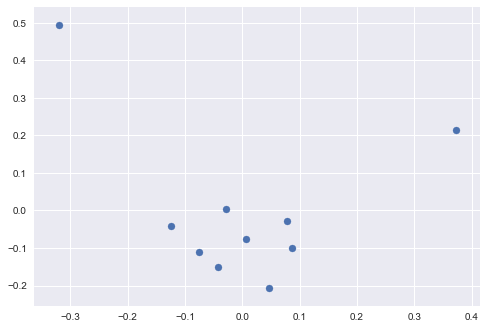

In [16]:
plt.scatter(out[0], out[1])